In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_auc_score, roc_curve
# from dataProcessing import dataSplit
# from data import getData
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
import talib
import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBClassifier, plot_importance
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from py5paisa import FivePaisaClient

In [13]:
client = FivePaisaClient(email="52119099", passwd="#bhola@1996", dob="19840101")
client.login()
scriptDf = pd.read_csv('../HistoricalData/NSECashScripts.csv')

 13:41:22 | Logged in!!


In [27]:
def getData(symbol,start,end):   
    try:
        scode = int(scriptDf[scriptDf['Name']==symbol.upper()]['Scripcode'])
        data = client.historical_data('N' , 'C' , scode ,'1m', start ,end)
        data.set_index('Datetime' , inplace=True)
        data.index = pd.to_datetime(data.index)
        return data
    except Exception as e:
            print("Error : " , e) 



def dataSplit(dataset):
    dataset.dropna(inplace=True)
    m = int(len(dataset) * 0.8)
    trainData = dataset[:m]
    testData = dataset[m:]
    y_train = trainData.iloc[:,6]
    X_train = trainData.iloc[:,7:]
    
    X_train,y_train = balanceData(X_train,y_train)
    y_test = testData.iloc[:,6]
    X_test = testData.iloc[:,7:]
    return X_train,y_train,X_test,y_test  


def balanceData(X,y):
    if(sum(y==1)/sum(y==0)<=0.85) or (sum(y==0)/sum(y==1)<=0.85):
        sm = SMOTE(random_state=2)
        X, y = sm.fit_resample(X, y)    
    return pd.DataFrame(X),pd.Series(y)

In [15]:
end = datetime.datetime.now()
start = end - datetime.timedelta(100)
# Defining the random state
seed(1)
set_random_seed(2)
#Text formatting
boldTextStart = "\033[1m"
boldTextEnd = "\033[0;0m"

In [16]:
def createFeatures(dataset,column):
    
    #Target variable construction
    dataset['Returns'] = np.log(dataset[column] / dataset[column].shift(1))
    dataset['Directions'] = np.sign(dataset['Returns'])
    dataset['Directions'] = np.where(dataset['Directions'] == 1, 1, 0)
    dataset['Directions'] = dataset['Directions']

    dataset['H-L'] = dataset['High'].shift(1) - dataset['Low'].shift(1)
    dataset['O-L'] = dataset['Open'].shift(1) - dataset['Low'].shift(1)
    dataset['C-L'] = dataset['Close'].shift(1) - dataset['Low'].shift(1)
    dataset['H-O'] = dataset['High'].shift(1) - dataset['Open'].shift(1)
    dataset['H-C'] = dataset['High'].shift(1) - dataset['Close'].shift(1)
    dataset['O-C'] = dataset['Open'].shift(1) - dataset['Close'].shift(1)
    #technical indicators
    dataset['ATR'] = talib.ATR(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ADX'] = talib.ADX(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=5)
    dataset['RSI'] = talib.RSI(dataset['Close'].shift(1).values, timeperiod = 10)
    dataset['ADOSC'] = talib.ADOSC(dataset['High'].shift(1).values, dataset['Low'].shift(1).values,dataset['Close'].shift(1).values,np.asarray(dataset['Volume'].shift(1).values,dtype='float'), fastperiod=5, slowperiod=20)
    
    dataset['BB_Upper'], dataset['BB_Middle'], dataset['BB_Lower'] = talib.BBANDS(dataset['Close'].shift(1).values, timeperiod=20)
    dataset['CCI'] = talib.CCI(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ROC'] = talib.ROC(dataset['Close'].shift(1).values, timeperiod=5)
    days_list = [5,10,50,100,200]
    dataset['FI_1'] = FORCE(dataset,1)
    dataset['FI_3'] = FORCE(dataset,3)
    dataset['FI_5'] = FORCE(dataset,5)
    for days in days_list:
        dataset['sma_%s' % days] = dataset['Close'].shift(1).rolling(window = days).mean()
        dataset['ewma_%s' % days]  = talib.EMA(dataset['Close'].shift(1).values,days)
    
    return dataset

def FORCE(dataset, n):  
    F = pd.Series(dataset['Close'].shift(1).diff(n) * dataset['Volume'].shift(1).diff(n), name = 'Force_' + str(n))  
    return F

In [17]:
def modelBuildXGB(X,y,n_estimator,learning_rate,max_depth,min_child_weight,gamma,colsample_bytree):
    xgb= XGBClassifier( n_estimator= n_estimator, 
                    learning_rate= learning_rate, 
                    max_depth= max_depth,  
                    min_child_weight=min_child_weight,
                    gamma=gamma,
                    colsample_bytree=colsample_bytree,
                    objective= 'binary:logistic', 
                    random_state= 2019,
                    n_jobs=-1)
    xgb.fit(X,y)
    return xgb

In [18]:
def create_model(xtrain,unit,optimizer,kernel_init,activation,reg):
    classifier = Sequential()
    classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation,  
                         activity_regularizer=reg, input_dim = xtrain.shape[1]))
    classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
def train_model(model, xtrain, ytrain,checkpoint,stoppoint,batch_size,epochs):    
    model.fit(xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_split= 0.3 , 
              callbacks=[checkpoint, stoppoint],verbose=1)
    return model.history
def plotHistory(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def plotMetrics(threshold, X_test_scaled, y_test):
    model = load_model('model.h5')
    y_pred = model.predict(X_test_scaled)
    y_pred = (y_pred > threshold)
    print(boldTextStart,'Accuracy:',boldTextEnd)
    accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
    print(accuracy_model,' %')
    print(boldTextStart,'Confusion Matrix:',boldTextEnd)
    print(confusion_matrix(y_test,y_pred))
    print(boldTextStart,'Classification Report:',boldTextEnd)
    print(classification_report(y_test,y_pred))
    auc = roc_auc_score(y_test,y_pred)
    print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

In [19]:
symbols = ['HDFCBANK',
 'ICICIBANK', 
 'SBIN',
 'KOTAKBANK',         
 'AXISBANK']

HDFCBANK


/home/rahul/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:29] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2576  176]
 [ 264 2205]]
0.9157249569048075
Plot feature importances...
AUC:  0.9145603153522281
ICICIBANK


/home/rahul/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:32] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2651  192]
 [ 267 2110]]
0.9120689655172414
Plot feature importances...
AUC:  0.9100696216570721
SBIN


/home/rahul/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:38] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2691  228]
 [ 220 2083]]
0.9142091152815014
Plot feature importances...
AUC:  0.913181742925243
KOTAKBANK


/home/rahul/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:41] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2472  196]
 [ 302 2249]]
0.9045794213450853
Plot feature importances...
AUC:  0.9040758922773032
AXISBANK


/home/rahul/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:45] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[2667  182]
 [ 252 2118]]
0.9168423069553554
Plot feature importances...
AUC:  0.9148944110969428


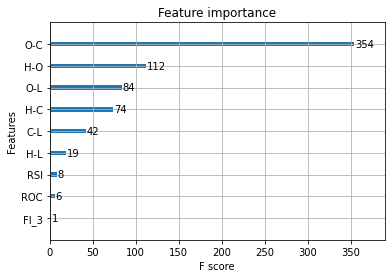

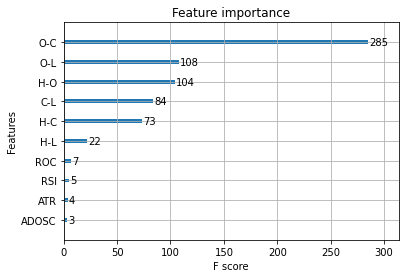

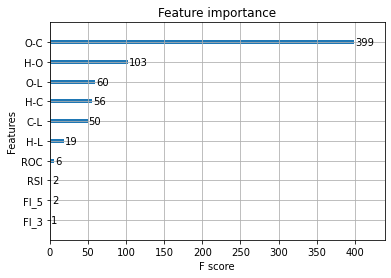

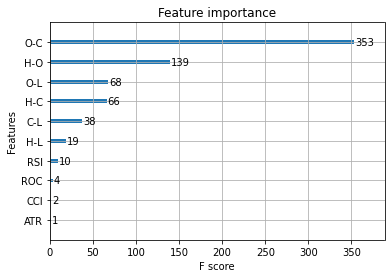

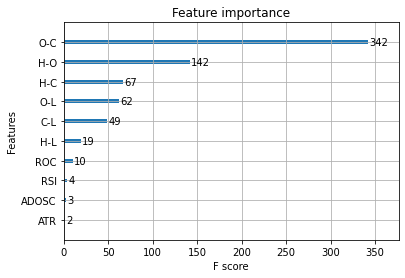

In [30]:
for symbol in symbols:
    print(symbol)
    data = getData(symbol,start,end)
    data = createFeatures(data,'Open')
    X_train,y_train,X_test,y_test = dataSplit(data)
    stack = modelBuildXGB(X_train,y_train,200,0.0001,3,3,0.3,0.5)
    y_pred = stack.predict(X_test)
    print(confusion_matrix(y_test,y_pred))
    accuracy = accuracy_score(y_test,y_pred)
    print(accuracy)
    print('Plot feature importances...')
    plot_importance(stack, max_num_features=10)
    auc = roc_auc_score(y_test,y_pred)
    print('AUC: ', auc)

In [33]:
for symbol in symbols:
    print(boldTextStart,symbol,boldTextEnd)
    data = getData(symbol,start,end)
    data = createFeatures(data,'Open')
    X_train,y_train,X_test,y_test = dataSplit(data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    unit = 20
    kernel_init = 'glorot_normal'
    activation = 'relu'
    reg = l1(0.001)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=0, monitor='val_acc',save_best_only=True, mode='auto')
    stoppoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
    batch_size = 2
    epochs = 100
    threshold = 0.5
    model = None
    model = create_model(X_train_scaled,unit,optimizer,kernel_init,activation,reg)
    history = train_model(model, X_train_scaled, y_train,checkpoint,stoppoint,batch_size,epochs)
    accuracy_history = history.history['acc']
    val_accuracy_history = history.history['val_acc']
    print("Last training accuracy: ",str(accuracy_history[-1]), ", last validation accuracy: ",str(val_accuracy_history[-1]))
    plotHistory(history)
    print(boldTextStart,symbol,boldTextEnd)
    plotMetrics(threshold, X_test_scaled, y_test)    

 HDFCBANK 
Error :  HTTPSConnectionPool(host='openapi.5paisa.com', port=443): Read timed out. (read timeout=None)


TypeError: 'NoneType' object is not subscriptable